# 1. Notebook setup & installs

In [1]:
# 1. Notebook setup & imports
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, losses, optimizers
from tensorflow.keras.datasets import mnist
import random
import os

# reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # less TF logging

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.19.0


# 2. Load & preprocess MNIST

In [2]:
# 2. Load & preprocess MNIST
(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.0
x_test  = x_test.astype('float32') / 255.0
x_train = np.expand_dims(x_train, -1)  # (N,28,28,1)
x_test  = np.expand_dims(x_test, -1)

print("Shapes: train", x_train.shape, "test", x_test.shape)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Shapes: train (60000, 28, 28, 1) test (10000, 28, 28, 1)


# 3. Build encoder (paste & run)

In [3]:
# 3. Build encoder
input_shape = (28, 28, 1)
latent_dim = 64

encoder_inputs = layers.Input(shape=input_shape, name='encoder_input')
x = layers.Conv2D(32, (3,3), activation='relu', padding='same')(encoder_inputs)
x = layers.MaxPooling2D((2,2), padding='same')(x)  # 14x14x32
x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2,2), padding='same')(x)  # 7x7x64
x = layers.Flatten()(x)
latent = layers.Dense(latent_dim, name='latent_vector')(x)

encoder = models.Model(encoder_inputs, latent, name='encoder')
print("Encoder built.")

Encoder built.


# 4. Build decoder

In [4]:
# 4. Build decoder
decoder_inputs = layers.Input(shape=(latent_dim,), name='decoder_input')
x = layers.Dense(7*7*64, activation='relu')(decoder_inputs)
x = layers.Reshape((7,7,64))(x)
x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2,2))(x)  # 14x14x64
x = layers.Conv2D(32, (3,3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2,2))(x)  # 28x28x32
decoder_outputs = layers.Conv2D(1, (3,3), activation='sigmoid', padding='same')(x)

decoder = models.Model(decoder_inputs, decoder_outputs, name='decoder')
print("Decoder built.")

Decoder built.


# 5. Build & compile autoencoder

In [5]:
# 5. Build & compile autoencoder
ae_inputs = encoder_inputs
ae_latent = encoder(ae_inputs)
ae_outputs = decoder(ae_latent)
autoencoder = models.Model(ae_inputs, ae_outputs, name='autoencoder')

autoencoder.compile(optimizer=optimizers.Adam(1e-3), loss=losses.MeanSquaredError())
print("Autoencoder compiled.")

Autoencoder compiled.


# 6. Show model summaries

In [6]:
# 6. Display model summaries
print("\n=== Encoder Summary ===")
encoder.summary()
print("\n=== Decoder Summary ===")
decoder.summary()
print("\n=== Autoencoder Summary ===")
autoencoder.summary()


=== Encoder Summary ===


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)      │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent_vector (Dense)           │ (None, 64)             │       200,768 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 219,584 (857.75 KB)

 Trainable params: 219,584 (857.75 KB)

 Non-trainable params: 0 (0.00 B)


=== Decoder Summary ===


Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)      │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3136)           │       203,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 14, 14, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 28, 28, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 259,521 (1013.75 KB)

 Trainable params: 259,521 (1013.75 KB)

 Non-trainable params: 0 (0.00 B)


=== Autoencoder Summary ===


Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)      │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder (Functional)            │ (None, 64)             │       219,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 28, 28, 1)      │       259,521 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 479,105 (1.83 MB)

 Trainable params: 479,105 (1.83 MB)

 Non-trainable params: 0 (0.00 B)

# 7. Train the autoencoder

In [7]:
# 7. Train the autoencoder
epochs = 20
batch_size = 128

history = autoencoder.fit(
    x_train, x_train,
    epochs=epochs,
    batch_size=batch_size,
    shuffle=True,
    validation_split=0.1,
    verbose=2
)

Epoch 1/20
422/422 - 13s - 31ms/step - loss: 0.1133 - val_loss: 0.1114
Epoch 2/20
422/422 - 3s - 7ms/step - loss: 0.1121 - val_loss: 0.1114
Epoch 3/20
422/422 - 3s - 7ms/step - loss: 0.1121 - val_loss: 0.1114
Epoch 4/20
422/422 - 3s - 7ms/step - loss: 0.1121 - val_loss: 0.1114
Epoch 5/20
422/422 - 3s - 7ms/step - loss: 0.1121 - val_loss: 0.1114
Epoch 6/20
422/422 - 3s - 7ms/step - loss: 0.1121 - val_loss: 0.1114
Epoch 7/20
422/422 - 3s - 7ms/step - loss: 0.1121 - val_loss: 0.1114
Epoch 8/20
422/422 - 3s - 7ms/step - loss: 0.1121 - val_loss: 0.1114
Epoch 9/20
422/422 - 3s - 7ms/step - loss: 0.1121 - val_loss: 0.1114
Epoch 10/20
422/422 - 3s - 7ms/step - loss: 0.1121 - val_loss: 0.1114
Epoch 11/20
422/422 - 3s - 7ms/step - loss: 0.1121 - val_loss: 0.1114
Epoch 12/20
422/422 - 3s - 7ms/step - loss: 0.1121 - val_loss: 0.1114
Epoch 13/20
422/422 - 3s - 7ms/step - loss: 0.1096 - val_loss: 0.0608
Epoch 14/20
422/422 - 3s - 7ms/step - loss: 0.0145 - val_loss: 0.0066
Epoch 15/20
422/422 - 3s - 

# 8. Plot training & validation loss

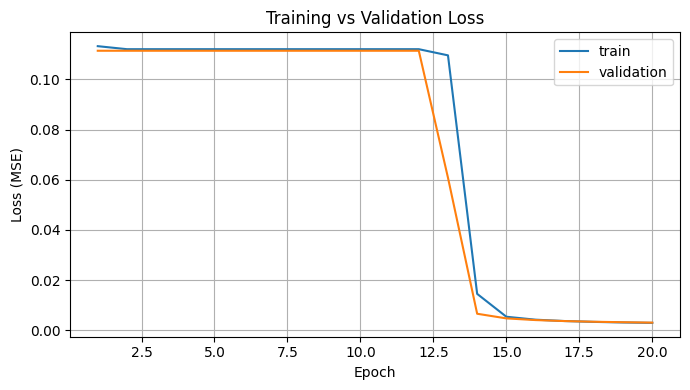

<Figure size 640x480 with 0 Axes>

In [8]:
# 8. Plot training & validation loss
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(train_loss) + 1)

plt.figure(figsize=(7,4))
plt.plot(epochs_range, train_loss, label='train')
plt.plot(epochs_range, val_loss, label='validation')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# optional: save
plt.savefig('loss_curve.png', dpi=150, bbox_inches='tight')

# 9. Reconstruct & visualize test images

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


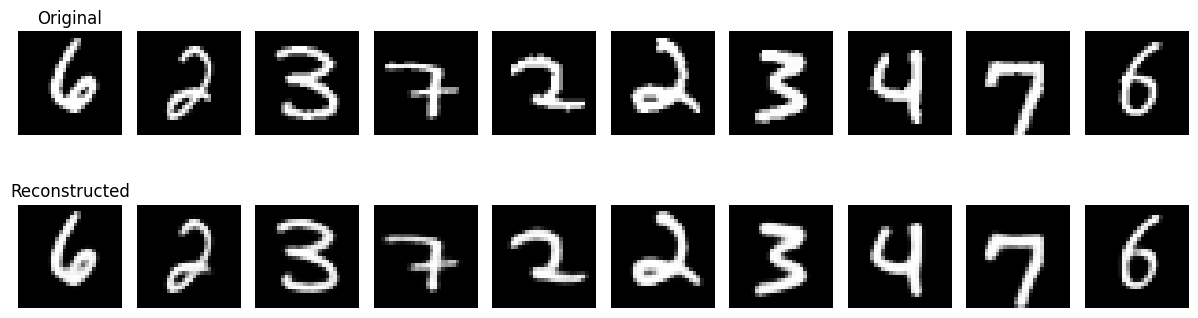

<Figure size 640x480 with 0 Axes>

In [9]:
# 9. Visualize original vs reconstructed images
num_examples = 10
indices = np.random.choice(len(x_test), num_examples, replace=False)
examples = x_test[indices]
reconstructions = autoencoder.predict(examples)

plt.figure(figsize=(12, 4))
for i in range(num_examples):
    ax = plt.subplot(2, num_examples, i + 1)
    plt.imshow(examples[i].squeeze(), cmap='gray')
    plt.axis('off')
    if i == 0:
        ax.set_title('Original')

    ax = plt.subplot(2, num_examples, num_examples + i + 1)
    plt.imshow(reconstructions[i].squeeze(), cmap='gray')
    plt.axis('off')
    if i == 0:
        ax.set_title('Reconstructed')

plt.tight_layout()
plt.show()

# optional: save
plt.savefig('reconstructions.png', dpi=150, bbox_inches='tight')

# 10. Print final loss numbers

In [10]:
# 10. Print final loss numbers
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]
print(f"Final training loss: {final_train_loss:.6f}")
print(f"Final validation loss: {final_val_loss:.6f}")

Final training loss: 0.002959
Final validation loss: 0.003062


# 11. Save models

In [12]:
# 11. Save models (Keras format)
encoder.save('encoder_model.keras')
decoder.save('decoder_model.keras')
autoencoder.save('autoencoder_model.keras')

print("✅ Models saved successfully in .keras format!")

✅ Models saved successfully in .keras format!
